# Imports

In [1]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [2]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           calculate_parameter_sensitivity,
                           plot_parameters_kde,
                           plot_parameter_sensitivity,
                           plot_regression_fit)

INFO:myokit:Loading Myokit version 1.27.4


In [3]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [4]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Create ion channel model

In [5]:
from channels.ical import ical as model
#model.sample({})

# Get experimental measurements

In [6]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [7]:
limits = dict(g_CaL=(0, 0.001),
              p1=(-50, 50),
              p2=(0, 100),
              p3=(-100, 100),
              p4=(-100, 100),
              p5=(-100, 100),
              p6=(-100, 100),
              p7=(0, 1000),
              p8=(0, 1000),
              q1=(0, 100),
              q2=(-100, 100),
              q3=(0, 10000),
              q4=(0, 200),
              q5=(-1000, 1000),
              q6=(0, 1000),
              q7=(0, 100),
              q8=(0, 100),
              q9=(-1000,1000),
              r1=(0, 1),
              r2=(0, 1),
              r3=(0, 1),
              r4=(0, 1),
              r5=(0, 1),
              r6=(0, 1),
              r7=(0, 1),
              r8=(0, 1),
              r9=(0, 10))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Test parameter sensitivity

In [9]:
parameters = ['ical.'+k for k in limits.keys()]

In [10]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

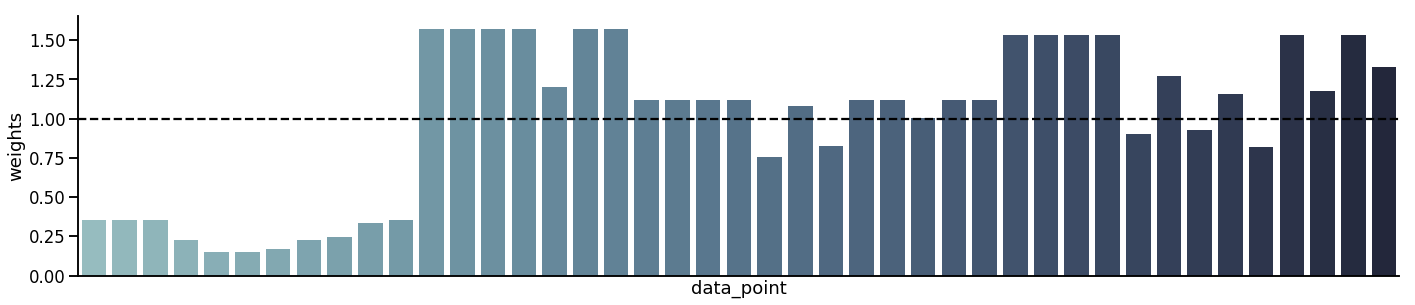

In [11]:
from ionchannelABC import plot_distance_weights
sns.set_context('talk')
grid = plot_distance_weights(model, distance_fn)
grid.savefig('results/ical/dist_weights.pdf')

In [14]:
fitted, regression_fit, r2 = calculate_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.1,
    n_samples=1000)

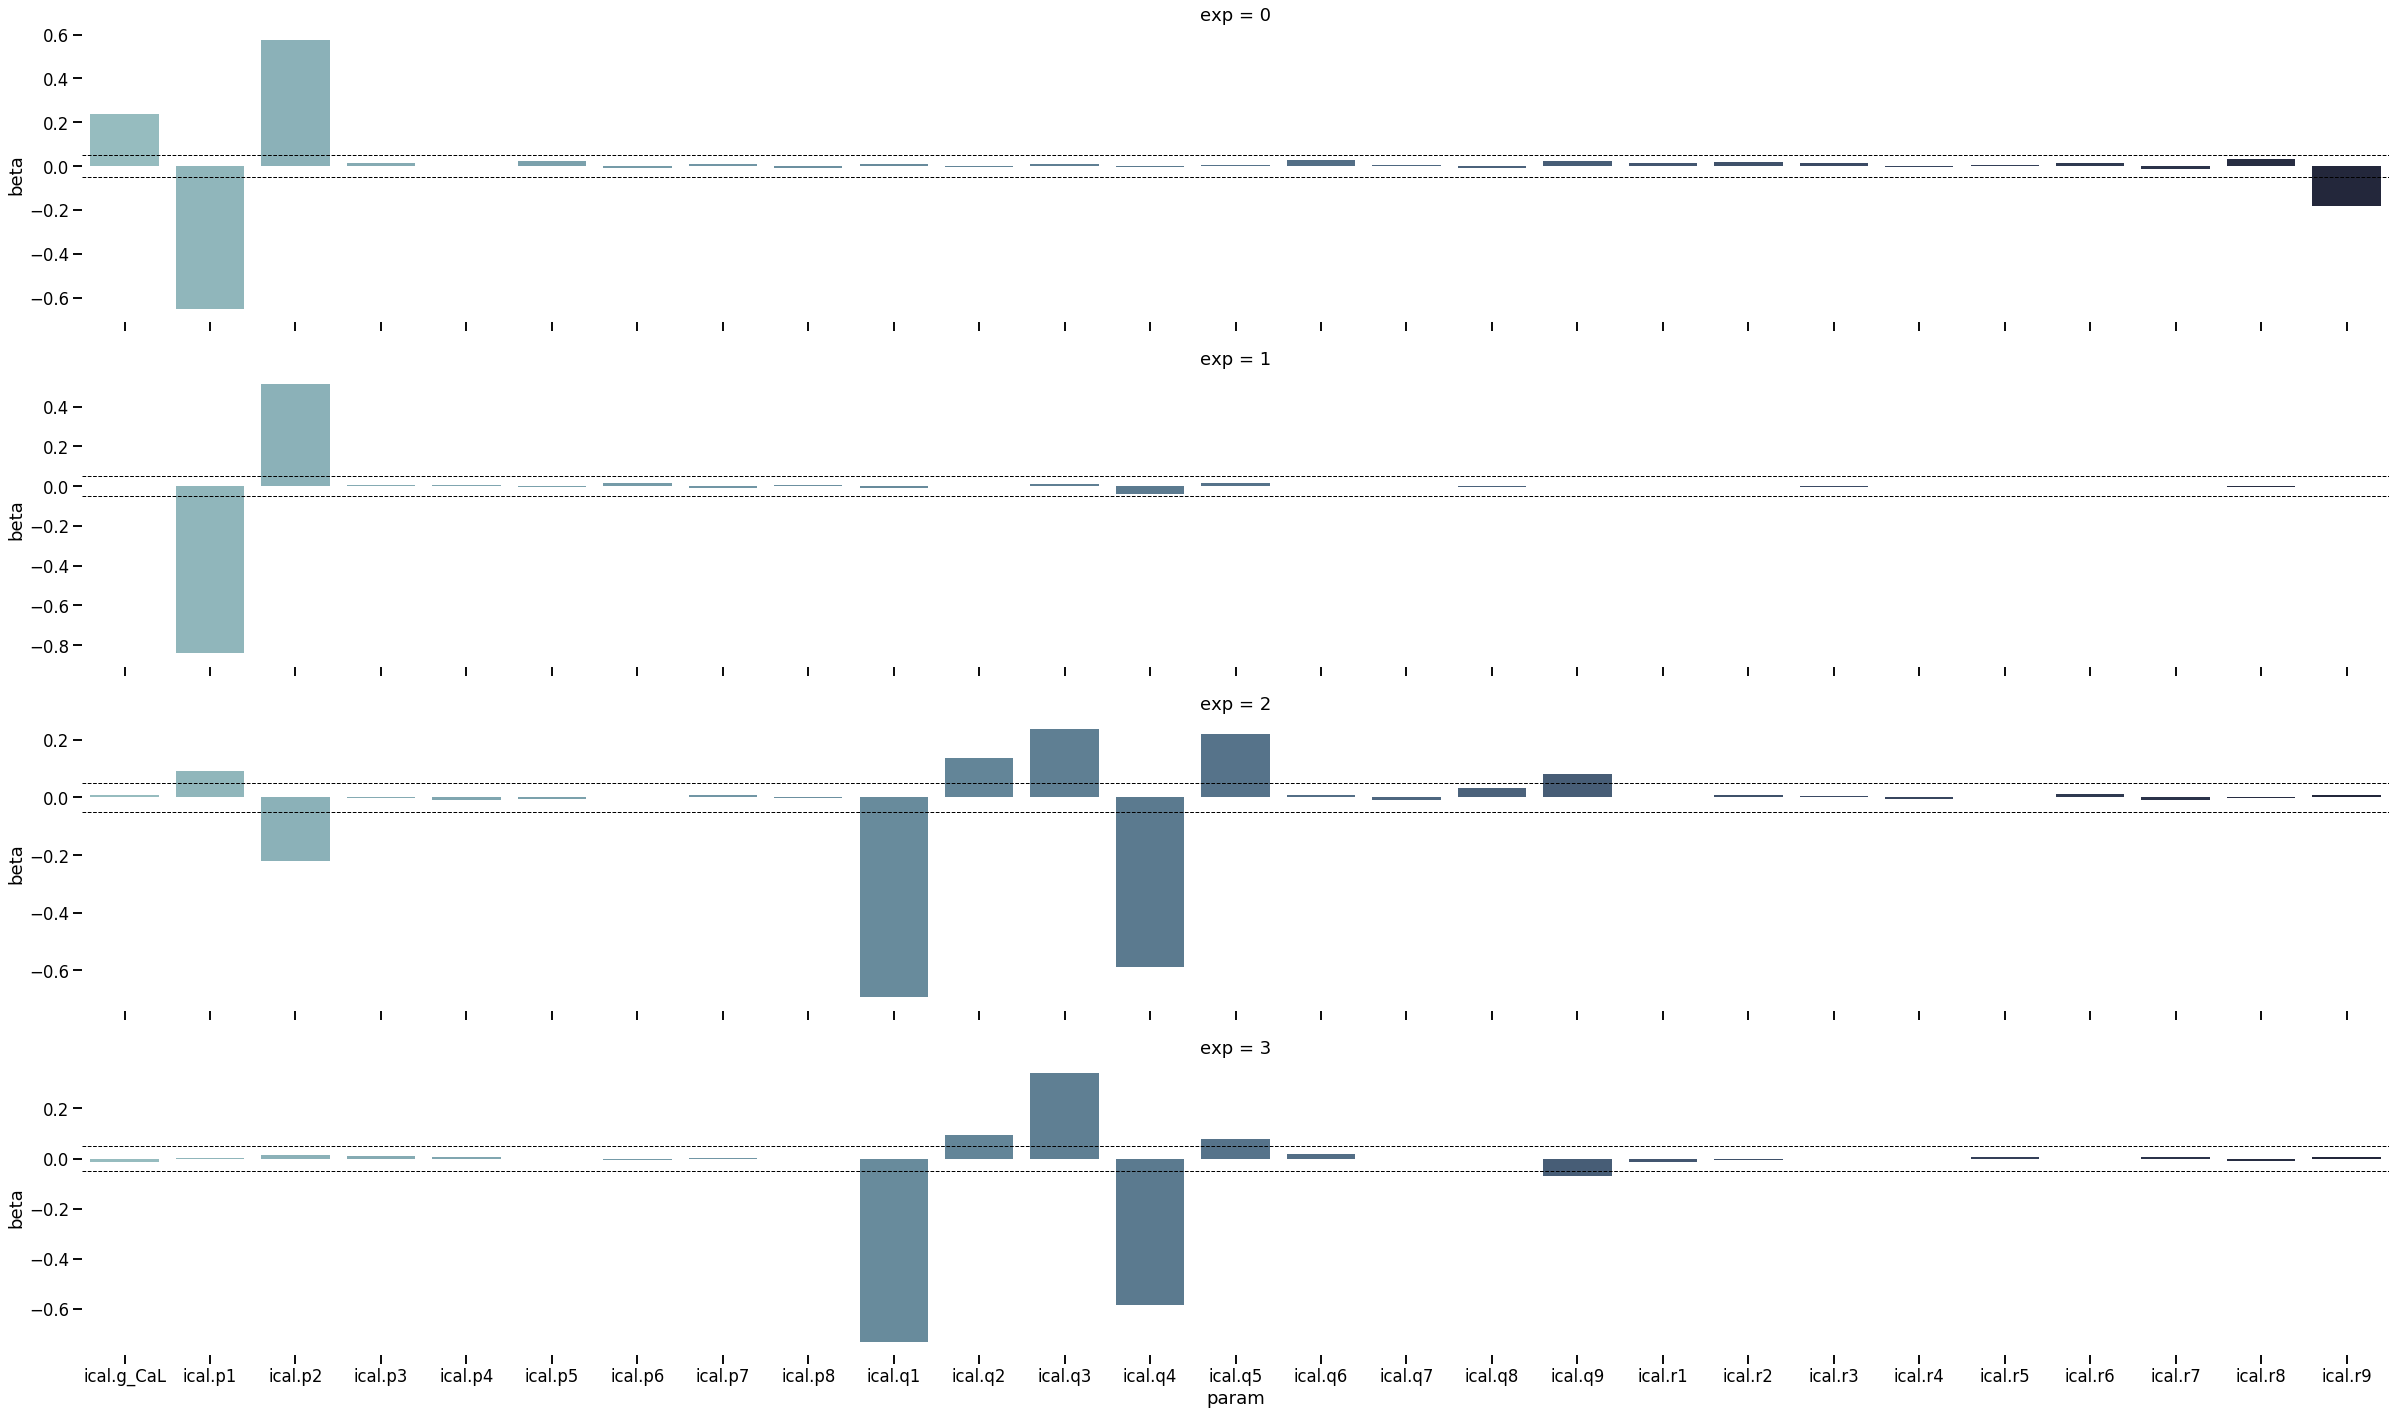

In [15]:
sns.set_context('talk')
grid = plot_parameter_sensitivity(fitted, plot_cutoff=0.05)

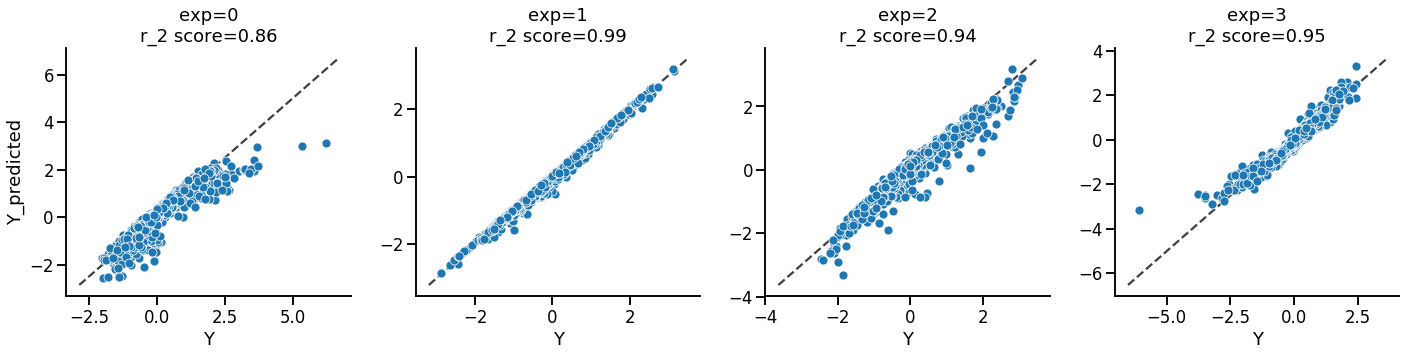

In [17]:
grid2 = plot_regression_fit(regression_fit, r2)

In [19]:
grid.savefig('results/ical/sensitivity.pdf')
grid2.savefig('results/ical/sensitivity_fit.pdf')

In [7]:
# New limits eliminating insensitive parameters
limits = dict(g_CaL=(0, 0.001),
              p1=(-50, 50),
              p2=(0, 100),
              q1=(0, 100),
              q2=(-100, 100),
              q3=(0, 10000),
              q4=(0, 200),
              q5=(-1000, 1000),
              q9=(-1000,1000),             
              r9=(0, 10))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Initialise pyabc database

In [9]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_ical.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_ical.db


In [10]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [11]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             population_size=AdaptivePopulationSize(
                 start_nr_particles=2000,
                 mean_cv=0.4,
                 max_population_size=2000,
                 min_population_size=100),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=6),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.35660656938246293, 1: 0.35660656938246293, 2: 0.35660656938246293, 3: 0.2235508569788746, 4: 0.14818305191086062, 5: 0.14818305191086062, 6: 0.16990123682780803, 7: 0.22754257892652202, 8: 0.24501057926385836, 9: 0.3352837664439712, 10: 0.35660656938246293, 11: 1.574893351215255, 12: 1.574893351215255, 13: 1.574893351215255, 14: 1.574893351215255, 15: 1.1991074553643941, 16: 1.574893351215255, 17: 1.574893351215255, 18: 1.1217956589353755, 19: 1.1217956589353755, 20: 1.1217956589353755, 21: 1.1217956589353755, 22: 0.7585517117689706, 23: 1.0822285804786025, 24: 0.8281937231104962, 25: 1.1217956589353755, 26: 1.1217956589353755, 27: 1.0020504889481259, 28: 1.1217956589353755, 29: 1.1217956589353755, 30: 1.5324625057607502, 31: 1.5324625057607502, 32: 1.5324625057607502, 33: 1.5324625057607502, 34: 0.9039307823835155, 35: 1.2728821221318876, 36: 0.930913790812873, 37: 1.1550226663789356, 38: 0.8206739997955603, 39: 1.5324625057607502, 40: 1.1768155468

In [ ]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=5, start_time=2018-11-04 21:25:22.671841, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=20, min_acceptance_rate=0.01)

In [ ]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=20, min_acceptance_rate=0.01)

In [ ]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=20, min_acceptance_rate=0.01)

# Results analysis

In [9]:
db_path = "sqlite:////scratch/cph211/ion-channel-ABC/docs/examples/results/ical/hl-1_ical.db"
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-11-04 12:55:32.216463, end_time=2018-11-04 20:49:17.431045)>,
 <ABCSMC(id=2, start_time=2018-11-04 21:14:34.705560, end_time=None)>,
 <ABCSMC(id=3, start_time=2018-11-04 21:14:50.364813, end_time=None)>,
 <ABCSMC(id=4, start_time=2018-11-04 21:15:41.093574, end_time=None)>,
 <ABCSMC(id=5, start_time=2018-11-04 21:25:22.671841, end_time=2018-11-05 06:55:30.231782)>]

In [10]:
history.id = 5

In [11]:
sns.set_context('talk')

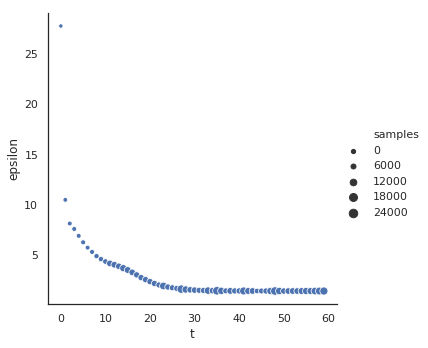

In [15]:
evolution = history.get_all_populations()
grid = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])
grid.savefig('results/ical/eps_evolution.pdf')

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()


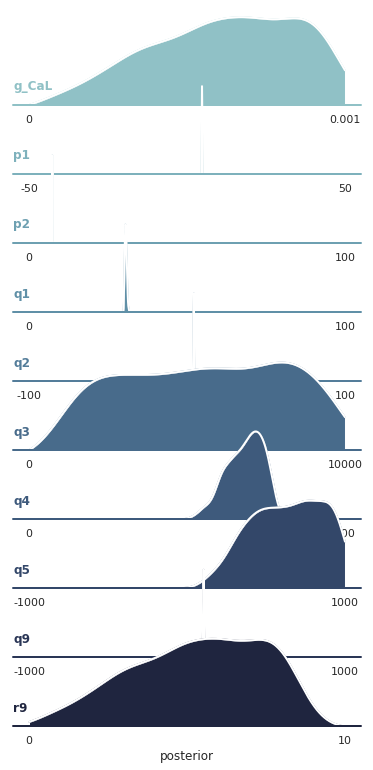

In [13]:
df, w = history.get_distribution(m=0)
g = plot_parameters_kde(df, w, limits, aspect=5, height=1.1)

In [14]:
g.savefig('results/ical/parameters_kde.pdf')

# Samples for quantitative analysis

In [16]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [17]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


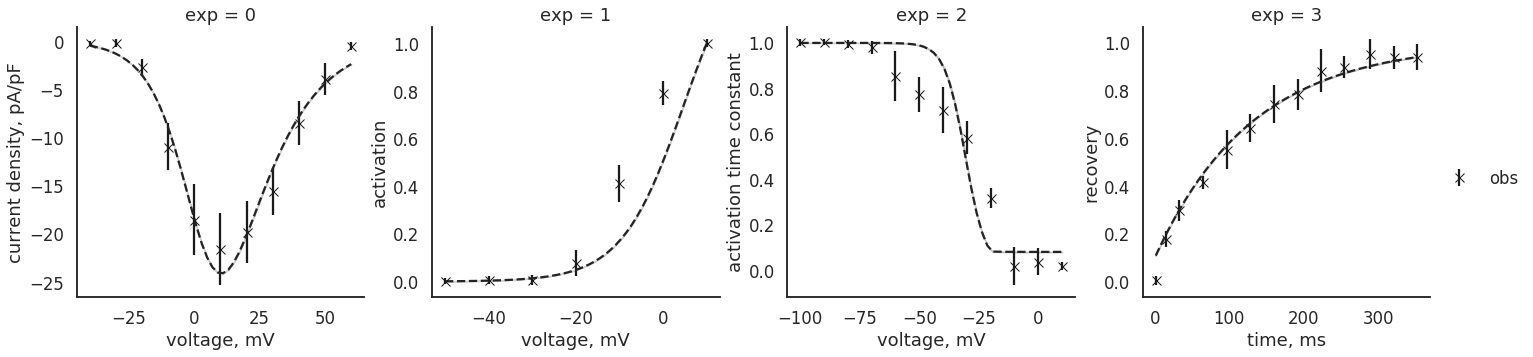

In [18]:
from ionchannelABC import plot_sim_results
sns.set_context('talk')
g = plot_sim_results(samples, obs=measurements)

# Set axis labels
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms"]
ylabels = ["current density, pA/pF", "activation", "activation time constant", "recovery"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)

In [19]:
g.savefig('results/ical/ical_sim_results.pdf')

In [20]:
# Peak current density
grouped = samples[samples['exp']==0].groupby('sample')
output = grouped.apply(min)['y']
print(output.mean())
print(output.std())

-24.07366908148886
0.032248573476081156


In [21]:
import scipy.stats as st
peak_current = samples[samples['exp']==0].groupby('sample').min()['y'].tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))

In [22]:
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -24.076667299175305
95% CI: (-24.13380136281377, -24.0104758632713)


In [23]:
# Half-activation voltage and slope factor
grouped = samples[samples['exp']==1].groupby('sample')
from scipy.optimize import curve_fit
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((Vhalf-V)/Shalf))
    guess = (-10, 5)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [24]:
print(output.mean())
print(output.std())

0   -0.895827
1    5.234979
dtype: float64
0    0.012268
1    0.007639
dtype: float64


In [25]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -0.8968897837495509
95% CI: (-0.9180554566023461, -0.8715669557512763)


In [26]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 5.233569744399952
95% CI: (5.219900310393966, 5.250324092633996)


In [27]:
# Half-inactivation voltage and slope factor
grouped = samples[samples['exp']==2].groupby('sample')
from scipy.optimize import curve_fit
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((Vhalf-V)/Shalf))
    guess = (-30, -5)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [28]:
print(output.mean())
print(output.std())

0   -30.479600
1    -4.672877
dtype: float64
0    0.329846
1    0.283598
dtype: float64


In [29]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -30.459869208443717
95% CI: (-31.19312735922847, -29.9398260442192)


In [30]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -4.675507455802916
95% CI: (-5.221714351231287, -4.119502145025784)


In [31]:
# Recovery dynamics
grouped = samples[samples['exp']==3].groupby('sample')
def fit_single_exp(group):
    def single_exp(t, I_max, tau):
        return I_max*(1-np.exp(-t/tau))
    guess = (1, 100)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt[1]
output = grouped.apply(fit_single_exp).apply(pd.Series)

In [32]:
print(output.mean())
print(output.std())

0    103.077216
dtype: float64
0    0.934001
dtype: float64


In [33]:
tau = output[0].tolist()
rv = st.rv_discrete(values=(tau, [1/len(tau),]*len(tau)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 103.108630665337
95% CI: (101.2612299096896, 104.71743105168005)
